In [1]:
import cv2
import numpy as np
import csv
import threading
from matplotlib import pyplot as plt
from Expression_Network import Expression_Network as enet
import traceback

# Test Face detection pipeline

faces found:  1


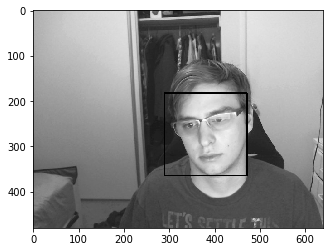

In [2]:
# initialize cascada classifier
haar_cascade = cv2.CascadeClassifier(
    'data/haarcascade_frontalface_alt.xml')

#initialize default. Change int argument to change webcam used.
cam = cv2.VideoCapture(0)

#read img from camera and make a gray version for the cascada classifier
ret_val, img = cam.read()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#use the classifier to detect faces. Returns face box coordinates for each face
faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
print("faces found: ", len(faces))

#for each face, draw a rectangle around it
for (x, y, w, h) in faces:     
         cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 255, 0), 2)

# display the img
plt.imshow(gray,cmap="gray")

# Import Labels

In [3]:
intToLabel = {}
with open('data/labelList.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        intToLabel[int(row[0])] = row[1]
print(intToLabel)

{0: 'Happy', 1: 'Sad', 2: 'Neutral', 3: 'Angry'}


# Detection/Prediction Pipeline
(only works with one face on screen at a time)


In [4]:
# Data class holds all of the information that all the other functions 
# need to pass between eachother. 
class data():
    def __init__(self):
        #coordinate array of the last faces detected
        self.faces = None
        #latist image from camera
        self.latestim = None
        # whether there is a camera image
        self.gotimage = False
        # whether there is a face detected
        self.gotface = False
        # blk and white zoomed in image of face
        self.faceim = None
        # emotion prediction
        self.prediction = None
        # True if user has quit program. Tells other processes to stop
        self.done = False


#Gets face coordinates
def get_faces(data):
    try:
        print("detecting faces")
        #if we haven't quit the program and have an image to detect faces in
        while not data.done:
            if data.gotimage:
                # get face coordinates and write them to data
                newfaces = haar_cascade.detectMultiScale(data.latestim, scaleFactor=1.1, minNeighbors=5)
                data.faces = newfaces
                data.gotface = True
        print("face detection stopped")
    except Exception as e:
        print("exception in get_faces loop")
        traceback.print_exc()
        data.done = True
            

def display(data):
    try:
        cam = cv2.VideoCapture(0)
        while not data.done:
            ret_val, img = cam.read()
            img = cv2.flip(img,1)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #gray = cv2.flip(gray, 1)
            data.latestim = gray
            data.gotimage = True
            if data.gotface:
                for (x, y, w, h) in data.faces: 
                    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    #img = img[y:y+h,x:x+w] 
                    faceim = gray[y:y+h,x:x+w]
                    data.faceim = cv2.resize(faceim,(128,128))
                    label = "None" 
                    if data.prediction is not None:
                        labelIdx = np.where(data.prediction[0] == 1.0)[0][0]
                        label = intToLabel[labelIdx]

                    cv2.putText(img,label,
                                (x,y-5),cv2.FONT_HERSHEY_SIMPLEX,.5,(0,255,0))

            cv2.imshow('my webcam', img)

            if cv2.waitKey(1) == 27: 
                data.done= True
                break  # esc to quit
        cv2.destroyAllWindows()
    except Exception as e:
        data.done = True
        print("exception in display loop")
        traceback.print_exc()
            
           


In [5]:
shared = data()
network = enet(4)
threading.Thread(target=network.predict_loop,args=[shared]).start()
threading.Thread(target=display,args=[shared]).start()
threading.Thread(target=get_faces, args=[shared]).start()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
detecting faces
face detection stopped


In [2]:
import tensorflow as tf
from Expression_Network import Expression_Network
net = Expression_Network()


INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [1024,8] rhs shape= [256,8]
	 [[node save/Assign_7 (defined at C:\Users\ablac\Google Drive\Programming\Python\Expressions\Expression_Network.py:14)  = Assign[T=DT_FLOAT, _class=["loc:@fully_connected_1/weights"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fully_connected_1/weights, save/RestoreV2:7)]]

Caused by op 'save/Assign_7', defined at:
  File "c:\programdata\miniconda3\envs\testing\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\programdata\miniconda3\envs\testing\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "c:\programdata\miniconda3\envs\testing\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "c:\programdata\miniconda3\envs\testing\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "c:\programdata\miniconda3\envs\testing\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\IPython\core\interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\IPython\core\interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\IPython\core\interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-7c4441ba5aa5>", line 3, in <module>
    net = Expression_Network()
  File "C:\Users\ablac\Google Drive\Programming\Python\Expressions\Expression_Network.py", line 14, in __init__
    self.saver = tf.train.Saver()
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\training\saver.py", line 1102, in __init__
    self.build()
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\training\saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\training\saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\training\saver.py", line 795, in _build_internal
    restore_sequentially, reshape)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\training\saver.py", line 428, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\training\saver.py", line 119, in restore
    self.op.get_shape().is_fully_defined())
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\ops\state_ops.py", line 221, in assign
    validate_shape=validate_shape)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 64, in assign
    use_locking=use_locking, name=name)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "c:\programdata\miniconda3\envs\testing\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [1024,8] rhs shape= [256,8]
	 [[node save/Assign_7 (defined at C:\Users\ablac\Google Drive\Programming\Python\Expressions\Expression_Network.py:14)  = Assign[T=DT_FLOAT, _class=["loc:@fully_connected_1/weights"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fully_connected_1/weights, save/RestoreV2:7)]]


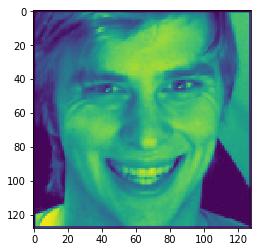

In [22]:
ret_val, img = cam.read()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
newfaces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
#gray = cv2.flip(gray, 1)

for (x, y, w, h) in newfaces: 
    cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 255, 0), 2)
    gray = gray[y:y+h,x:x+w]  
gray = cv2.resize(gray,(128,128))
plt.imshow(gray)

In [23]:
net.predict([gray])

array([[0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
class Expression_Network(object):
    def __init__(self):
        #hardcode in num_classes
        self.num_classes = 8
        self.x = tf.placeholder(dtype=tf.float32, shape=(None,128,128),name='x')
        self.model(self.x)
        self.sess = tf.Session()
        self.saver = tf.train.Saver()
        self.saver.restore(self.sess,"checkpoints/model.ckpt")


    def predict(self, img):
        return self.sess.run(self.prediction, feed_dict={self.x:img})
    
    def model(self, input):
        self.reshaped = tf.expand_dims(input, -1)
        # batch,128,128,1

        # first convolution
        self.conv = tf.contrib.layers.conv2d(
            self.reshaped,
            32,
            (9, 9),
            stride=(1, 1),
            padding='VALID',
            weights_initializer=tf.initializers.random_normal)
        # batch,120,120,32

        # subsample
        self.pool = tf.contrib.layers.max_pool2d(
            self.conv,
            (4, 4),
            stride=(4, 4))
        # batch,30,30,32

        # second convolution
        self.conv2 = tf.contrib.layers.conv2d(
            self.pool,
            64,
            (11, 11),
            stride=(1, 1),
            padding='VALID',
            weights_initializer=tf.initializers.random_normal)
        # batch,20,20,64

        # subsample
        self.pool2 = tf.contrib.layers.max_pool2d(
            self.conv2,
            (4, 4),
            stride=(4, 4))
        # batch,5,5,64

        # flatten
        self.flat = tf.contrib.layers.flatten(self.pool2)
        # batch,1600

        # fully connected
        self.fc = tf.contrib.layers.fully_connected(
            self.flat,
            1024,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.initializers.random_normal)
        # batch,256
        self.logits = tf.contrib.layers.fully_connected(
            self.fc,
            self.num_classes,
            weights_initializer=tf.initializers.random_normal,
            activation_fn=None)

        self.prediction = tf.nn.softmax(self.logits, )

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Conv_2/biases not found in checkpoint
	 [[node save_1/RestoreV2 (defined at <ipython-input-12-b59552dab075>:8)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]
	 [[{{node save_1/RestoreV2/_29}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_34_save_1/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'save_1/RestoreV2', defined at:
  File "c:\users\ablac\miniconda3\envs\expressions\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-65d7cb6305e5>", line 1, in <module>
    EN = Expression_Network()
  File "<ipython-input-12-b59552dab075>", line 8, in __init__
    self.saver = tf.train.Saver()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 1102, in __init__
    self.build()
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 795, in _build_internal
    restore_sequentially, reshape)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\training\saver.py", line 862, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1550, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "c:\users\ablac\miniconda3\envs\expressions\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Conv_2/biases not found in checkpoint
	 [[node save_1/RestoreV2 (defined at <ipython-input-12-b59552dab075>:8)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]
	 [[{{node save_1/RestoreV2/_29}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_34_save_1/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [4]:
import traceback
try:
    print(j)
except Exception as e:
    traceback.print_exc()

oops


In [1]:
int([0])

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'